Coryn Bailer-Jones, MPIA Heidelberg (https://mpia.de/homes/calj)

The main reference for this tutorial is [Bailer-Jones 2015](http://adsabs.harvard.edu/abs/2015PASP..127..994B)

# Global settings

Relative to the root directory, ensure that the R codes (*.R) are "Rcode/" and the data files (*.csv) are in "data/"

In [1]:
rootDir <- "./" # directory containing Rcode/ and data/ directories

In [2]:
setwd(paste(rootDir, "Rcode", sep=""))
conv <- pi/180 
source("general_functions.R")
source("distance_functions.R")
setwd("../")
library(MASS) # for truehist
library(fields) # for image.plot
library(RColorBrewer) # for colorRampPalette
mypalette <- colorRampPalette(brewer.pal(9, "Greys"), space="rgb", interpolate="linear", bias=2.5)
mycols <- mypalette(64)

Loading required package: spam
Loading required package: dotCall64
Loading required package: grid
Spam version 2.2-0 (2018-06-19) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: ‘spam’

The following objects are masked from ‘package:base’:

    backsolve, forwardsolve

Loading required package: maps
See www.image.ucar.edu/~nychka/Fields for
 a vignette and other supplements. 


# Draw from distance priors

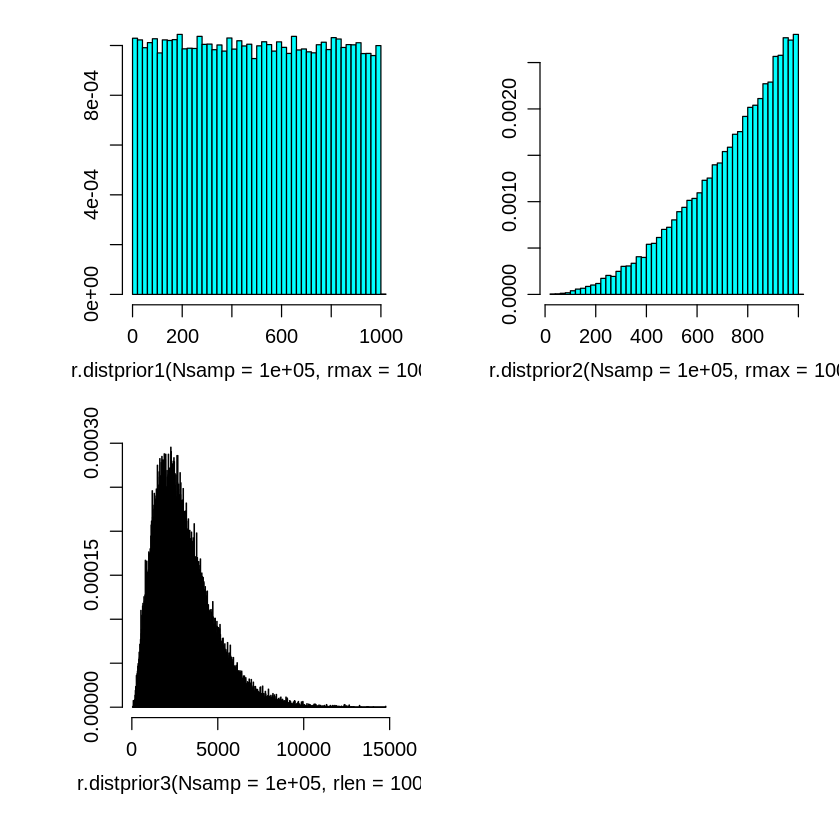

In [3]:
# Plot the priors to get feel for what they look like.
# To check the code, we draw from distance priors and plot the samples as a histogram. 
# 1,2,3 are uniform in distance, uniform space density, and exponentially decreasing space density, respectively.
par(mfrow=c(2,2), mar=c(5,5,0.5,1), oma=c(0.1,0.1,0.5,0.1), mgp=c(2.2,0.8,0), cex=1.0) 
truehist(r.distprior1(Nsamp=1e5, rmax=1e3), h=20)
truehist(r.distprior2(Nsamp=1e5, rmax=1e3), h=20)
truehist(r.distprior3(Nsamp=1e5, rlen=1e3), h=20)

# Posterior for a simulated parallax using the exponentially decreasing distance prior

I won't consider further the uniform distance or uniform space density priors. They are not recommended. But you can easily plot these and compute estimates from them as described in [Bailer-Jones 2015](http://adsabs.harvard.edu/abs/2015PASP..127..994B). See also [Astraatmadja & Bailer-Jones 2016a](http://adsabs.harvard.edu/abs/2016ApJ...832..137A).

mode        lo        hi        5%       50%       95% 
1097.8613  790.8947 1748.0496  813.0417 1419.8825 3440.2100

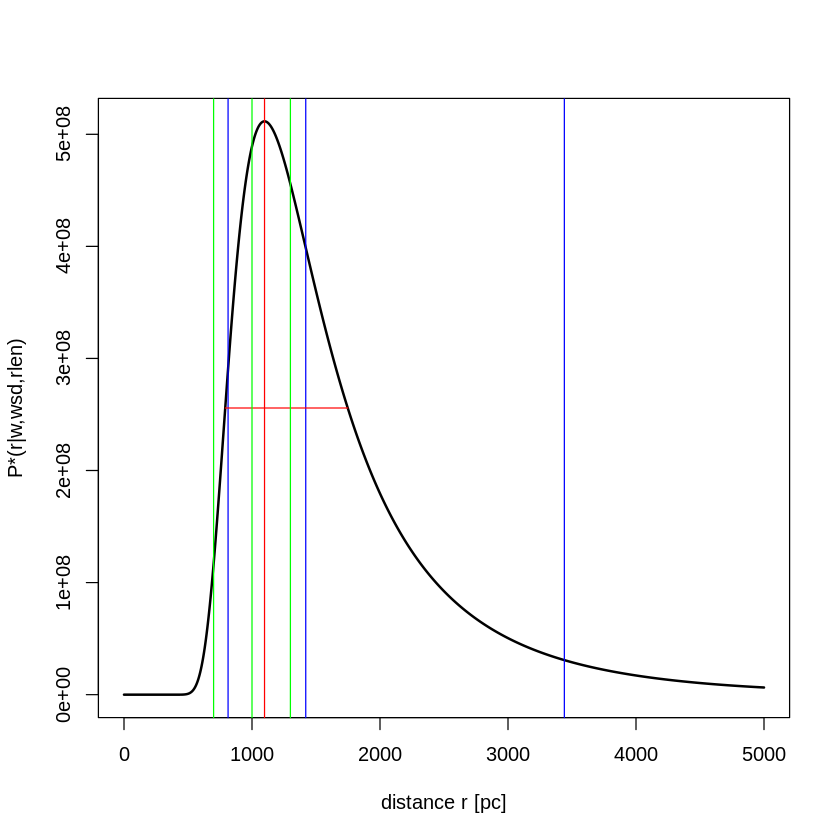

In [4]:
# Simulate parallax (w) and its uncertainty (wsd) (in as). You should experiment with changing these.
w    <- 1e-3
wsd  <- 3e-4
# Set length scale of the prior (in pc)
rlen <- 1e3
# Plot unnormalized posterior, P*(r|w,wsd,rlen).
# Compute and overplot the mode and FWHM (red) and the three quantiles 5%, 50% (median), 95% (blue).
# Note: The quantiles are computed via MCMC sampling, which is slow and sometimes inaccurate.
# Note: computation of the FWHM uses a root finding algorithm which may return warnings.
# Compute and overplot the distance from a naive parallax inversion and the uncertainty on this 
# from a first order uncertainty propagation (green).
r <- seq(from=0, to=5e3, length.out=1e3) # May need to change limits depending on values of simulated data.
plot(r, ud.distpost3(r, w, wsd, rlen), type="l", lwd=2, xlab="distance r [pc]", ylab="P*(r|w,wsd,rlen)")
rMode  <- mode.distpost3(w, wsd, rlen)
rFWHM  <- fwhm.distpost3(w, wsd, rMode=rMode, rlen, rmax=1e6) 
rQuant <- quantiles.distpost3(w, wsd, rlen, probs=c(0.05, 0.5, 0.95), Nsamp=1e5)
c(mode=rMode, rFWHM, rQuant) # FWHM given as "lo, hi", quantiles given as "5%, 50%, 95%"
abline(v=c(rMode, rQuant), col=c("red", rep.int("blue", length(rQuant))))
M <- ud.distpost3(r=rMode, w, wsd, rlen)
lines(x=c(rFWHM), y=c(M,M)/2, col="red")
abline(v=c(1/w, (1/w)+c(+1,-1)*wsd/w^2), col="green")

# Distance inference for multiple stars from GDR1

## Read and check GDR1 data

The following Gaia archive query was used to creates gdr1set01.csv (6909 sources):
```
select
parallax, parallax_error, l, b
from gaiadr1.tgas_source
where l > 175 and l < 185 and b > -5 and b < +5
```
Note the unfortunate choice of the field name "parallax_error". This is not the "error" in the parallax, but its uncertainty (defined as the standard deviation of the Gaussian likelihood).

In [5]:
# Note that parallaxes are in mas, angles in degrees
dat <- read.csv(paste(rootDir, "data/gdr1set01.csv", sep=""), sep=",")
# convert parallaxes to arcsec so that distances come out as pc
dat$parallax <- 1e-3*dat$parallax
dat$parallax_error <- 1e-3*dat$parallax_error

In [6]:
# Reduce the size of the data set for testing purposes
dat <- dat[1:10,]
dat

parallax,parallax_error,l,b
0.0003544360,0.0009808290,175.2932,-4.994473
0.0017235501,0.0002843546,175.1683,-4.150353
0.0004696314,0.0003569680,175.1830,-4.193350
0.0013279830,0.0004677145,175.1697,-4.573416
0.0016021144,0.0002714283,175.0998,-4.030721
0.0038513590,0.0002324245,175.0159,-3.711086
0.0011199443,0.0003135849,175.1362,-4.367051
0.0003205481,0.0002506443,175.0811,-4.690289
0.0016388455,0.0003956992,175.0806,-4.610517
0.0013188627,0.0002670727,175.1550,-4.655140


## Compute mode and FWHM of posterior
Now compute distance posterior for each star. Rather than plotting every posterior, I compute the mode and FWHM for each (and after than the quantiles). Note the following things about R:
1. I use the R function Vectorize to create an in-place version of the function mode.distpost3 to accept both w and wsd as vector arguments, which induces it to return a vector, namely the mode for each star.
2. Recall what was written above about the code for computing the FWHM possibly returning warnings.
3. I don't compute the mean and standard deviation. However, as my function to compute the quantiles draws samples (via MCMC), these samples could also be used to compute the mean (and higher moments).

In [7]:
rMode <- Vectorize(mode.distpost3, c("w", "wsd"))(w=dat$parallax, wsd=dat$parallax_error, rlen)
rFWHM <- Vectorize(fwhm.distpost3, c("w", "wsd", "rMode"))(w=dat$parallax, wsd=dat$parallax_error, rMode=rMode, rlen=rlen, rmax=1e6)
rFWHM <- t(rFWHM)
cbind(rMode, rFWHM)

rMode,lo,hi
2065.3055,944.4383,4161.7413
604.0960,501.5076,759.5778
2060.1100,1217.7406,3819.4863
899.7459,595.9186,1722.0357
650.4302,537.4952,823.4606
261.3139,243.8314,281.5017
978.8059,717.3162,1517.5688
2502.6507,1593.9393,4244.6950
666.8227,505.9770,976.9305
799.7472,637.7348,1070.7340


In [8]:
# Now compute the quantiles. As noted above, this uses MCMC, which is very slow.
# A grid would be faster, but its size/spacing would generally need to be optimized for every source separately.
rQuant <- Vectorize(quantiles.distpost3, c("w", "wsd"))(w=dat$parallax, wsd=dat$parallax_error, rlen, probs=c(0.05, 0.5, 0.95), Nsamp=1e5)
rQuant <- t(rQuant)

In [9]:
# Tabulate all results and compare. fobs is the observed fractional parallax uncertainty.
cbind(w=dat$parallax, fobs=dat$parallax_error/dat$parallax, rMode, rFWHM, rQuant)

w,fobs,rMode,lo,hi,5%,50%,95%
0.0003544360,2.76729539,2065.3055,944.4383,4161.7413,1031.6468,2806.7445,6371.9319
0.0017235501,0.16498195,604.0960,501.5076,759.5778,491.5037,644.1648,952.6583
0.0004696314,0.76010247,2060.1100,1217.7406,3819.4863,1292.5082,2754.4071,6098.8117
0.0013279830,0.35219917,899.7459,595.9186,1722.0357,655.5512,1423.0317,4247.1842
0.0016021144,0.16941877,650.4302,537.4952,823.4606,529.2350,699.3693,1041.6373
0.0038513590,0.06034871,261.3139,243.8314,281.5017,238.8982,263.0258,292.7080
0.0011199443,0.28000044,978.8059,717.3162,1517.5688,734.2660,1253.0884,3021.4597
0.0003205481,0.78192412,2502.6507,1593.9393,4244.6950,1629.8216,3127.5113,6331.3886
0.0016388455,0.24144996,666.8227,505.9770,976.9305,515.6021,817.1844,1956.3907
0.0013188627,0.20250230,799.7472,637.7348,1070.7340,632.2614,897.8218,1558.7822


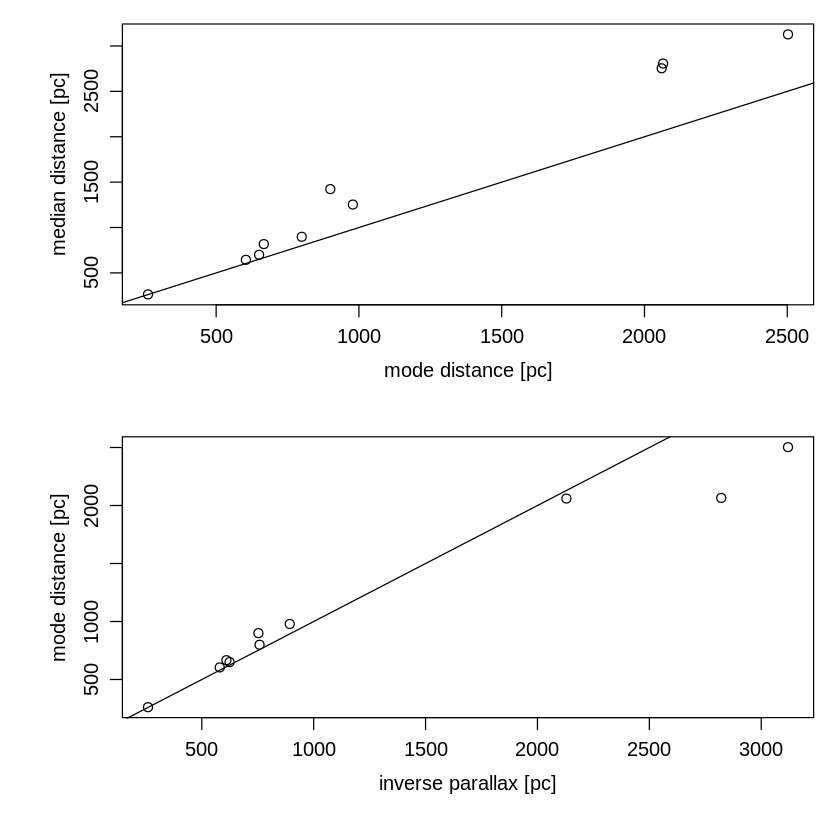

In [10]:
# Visually the mode of the posterior with the median and also the naive inverse parallax estimate
par(mfrow=c(2,1), mar=c(5,5,0.5,1), oma=c(0.1,0.1,0.5,0.1), mgp=c(2.2,0.8,0), cex=1.0) 
plot(rMode, rQuant[,2], xlab="mode distance [pc]", ylab="median distance [pc]")
abline(a=0, b=1)
plot(1/dat$parallax, rMode, xlab="inverse parallax [pc]", ylab="mode distance [pc]")
abline(a=0, b=1)

# Distance posterior with a hierarchical model for simulated data

Instead of fixing the length scale, $L$, in the exponential decreasing space density prior - as has been done so far - we can instead put a prior on $L$ and marginalize over all values of $L$. This is a simple example of a hierarchical model. I'll call the prior on $L$ the hyperprior, with parameters, $\phi$, and denote it $P(L, \phi)$. The posterior we now want is $P(r|\varpi,\phi)$, i.e. without any dependence on $L$. We need to relate this to the quantities we already know, namely the prior, $P(r|L)$, and the likelihood $P(\varpi|r)$, as well as the hyperprior. (For brevity I don't include the dependence on $\sigma_{\varpi}$ in my notation.) It follows from the basic rules of probability that
we can write

\begin{alignat}{2}
P(r|\varpi,\phi) &= \int P(r,L|\varpi,\phi) \ dL\\
                 &= \int P(r|\varpi,L) \ P(L|\varpi,\phi) \ dL\\ 
                 &= \int \frac{P(\varpi|r) \ P(r|L)}{P(\varpi|L)} \ \frac{P(\varpi|L)\ P(L|\phi)}{P(\varpi|\phi)} \ dL \\
                 &= \frac{1}{P(\varpi|\phi)} \int P(\varpi|r) \ P(r|L) \ P(L|\phi) \ dL \\
\end{alignat}

Line 2 shows that the new posterior is the non-hierarchical posterior averaged over the hyperprior. In going from line 2 to line 3 I have used Bayes theorem to rewrite both terms, then I have cancelled $P(\varpi|L)$. I have also used conditional independence in several places to remove dependencies. As $P(\varpi|\phi)$ is independent of r it is just a normalization constant, so if we only need the unnormalized posterior (which is the case below), we can ignore it. We can of course take the likelihood - $P(\varpi|r)$ - out of the integral. When we do that we see that the posterior is just proportional to the likelihood multipled by the hyperior-averaged prior. (The code below keeps this inside the integral.)

In [11]:
# The function ud.distpost3hierIntegrand returns the quantity under the integral on the last line above
# (i.e. the product of three probability densities) for given w, L, phi, and r. 
# Here I adopt a scaled and shifted beta function hyperior, specified by the function d.betagen (which is
# defined in the file general_functions.R). The hyperparameters phi are the two shape parameters. 
# As it's based on a beta function, this hyperprior is only non-zero over the range rlenRange.
# The lower limit - min(rlenRange) - must be >0, otherwise the prior P(r|L) evaluates to NaN (prior undefined).
ud.distpost3hierIntegrand <- function(rlen, r, w, wsd, rlenRange) {
  d.like(w=w, r=r, wsd=wsd)*d.distprior3(r=r, rlen=rlen)*d.betagen(x=rlen, xrange=rlenRange, shape1=1, shape2=1) 
}
# Simulate the parallax (w) and its uncertainty (wsd) (in as). You should experiment with changing these.
w   <- 5e-3
wsd <- 1e-3
# I will do the integration using Gaussian quadrature (with my function integrate.func, which is just a
# wrapper to "integrate" in R's stats package). Let's first test that for some value of r.
r <- 4e2
rlenRange <- c(1e1, 1e3)
integrate.func(f=ud.distpost3hierIntegrand, lower=rlenRange[1], upper=rlenRange[2], r=r, w=w, wsd=wsd, 
               rlenRange=rlenRange, subdivisions=1e3, rel.tol=1e-6, abs.tol=1e-6) 

[1] 0.008307778

Posterior mean, SD for r = 234.685 69.65924 kpc


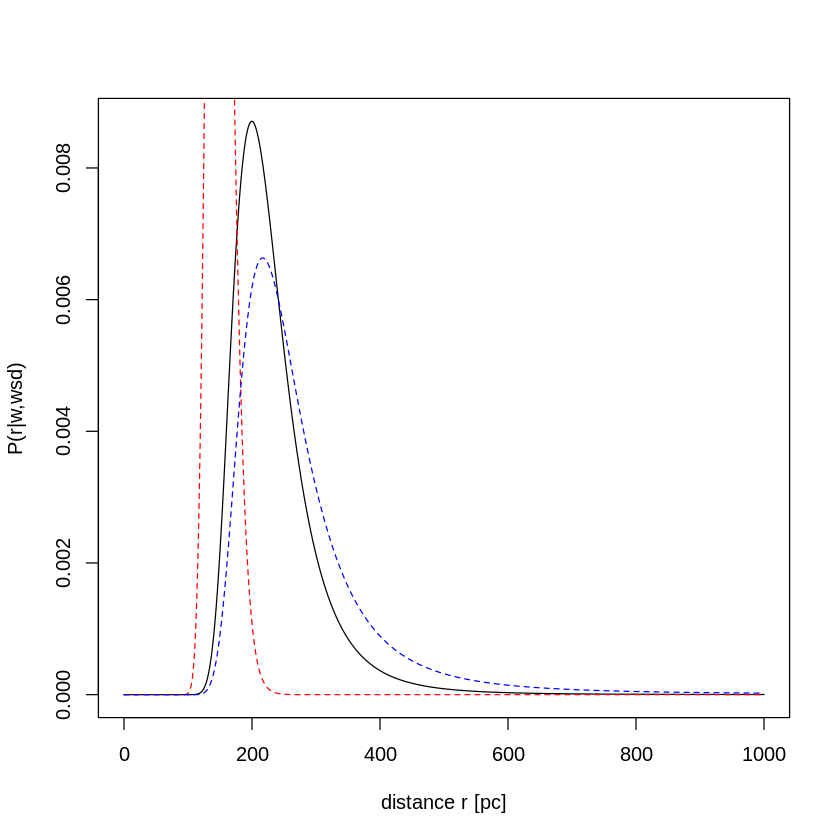

In [12]:
# Compute P*(r|w,phi) on a grid of r spanning (0,max(rlenRange)).
r <- seq(from=0, to=1e3, length.out=1e3)
udDistpost3hier <- double(length=length(r))
for(i in 1:length(r)) {
    udDistpost3hier[i] <- integrate.func(f=ud.distpost3hierIntegrand, lower=rlenRange[1], upper=rlenRange[2], 
                                         r=r[i], w=w, wsd=wsd, rlenRange=rlenRange, 
                                         subdivisions=1e3, rel.tol=1e-6, abs.tol=1e-6) 
}
# Note: Some integral may not converge, in which case integrate.func returns NA.
# I set these to zero for this demonstration (but really we should improve the integration routine!).
udDistpost3hier[is.na(udDistpost3hier)] <- 0
# Normalize the posterior, then plot (in black).
# Overplot the normalized posteriors we get with two different fixed values of rlen (in red and blue)
# Note 1: The function pdfmom normalizes a tabulated posterior on a grid, so it's important that the tabulated posterior
# includes all or nearly all of the probability mass. That is, the posteriors plotted should drop to zero for
# the largest values of r (= max(rlenRange)) plotted.
# Note 2: pdfmom computes the normalization constant numerically. It also computes the mean and variance. 
# We compute these from a *tabulated* posterior in a different way than from a *sampled* posterior. 
# See the code for pdfmom in general_functions.R, and sections 5.1.1 and 8.4 of Bailer-Jones 2015
mom <- pdfmom(udDistpost3hier, r)
cat("Posterior mean, SD for r =", mom$mean, mom$sd, "kpc\n")
udDistpost3hier <- udDistpost3hier/mom$Z # is now normalized
plot(r, udDistpost3hier, type="l", xlab="distance r [pc]", ylab="P(r|w,wsd)")
udDistpost3 <- ud.distpost3(r, w, wsd, rlen=min(rlenRange))
lines(r, udDistpost3/pdfmom(udDistpost3, r)$Z, lty=2, col="red") # posterior with rlen fixed to minimum of hyperprior range
udDistpost3 <- ud.distpost3(r, w, wsd, rlen=max(rlenRange))
lines(r, udDistpost3/pdfmom(udDistpost3, r)$Z, lty=2, col="blue") # posterior with rlen fixed to maximum of hyperprior range